# Example: Extrinsic calibration of 15 GoPro cameras

Suppose we have 15 GoPro cameras capturing a target.  This example demonstrates how to calibrate these cameras into a unified world coordinate system.  The steps include:

1. Intrinsic calibration
2. 2D corresponding points detection
3. Extrinsic calibration
   1. Linear calibration (intial guess)
   2. Non-linear optimization (bundle adjustment)
4. (optional) Scale / orientation adjustment

## Step 1: Intrinsic calibration

### 1-1: ChAruCo board

This cell defines the ChAruCo board to be detected.  Make sure you have captured this pattern from different orientations.  You can

1. print this pattern on a flat board or show this pattern on a flat-panel display, and
2. swing the pattern in front of the camera, or move the camera in front of the pattern.

The point is to capture the chess corners at the peripheral area of the camera frame to model the lens distortion accurately.  The ChAruCo pattern can partially go out of the camera frame.

![Sample video](../data/ba/gopro10-wide5.3k.gif)

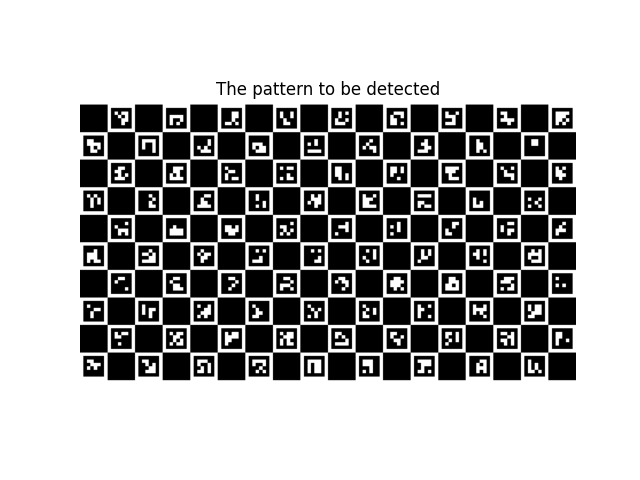

In [7]:
%matplotlib widget

import numpy as np
import sys
import os
import json
import bz2
import cv2
import matplotlib.pyplot as plt
import glob
import re
import pycalib  # pip install pycalib-simple

# Input mp4 file
INPUT_FILE = 'charuco_4x4_250_GP12_5K_Linear.mp4'
INPUT_FILE = '../data/ba/gopro10-wide5.3k.mp4'

FRAME_SKIP_BEGIN = 0
FRAME_SKIP = 0

# Output file
OUTPUT_FILE = 'output-in.json'

# [INPUT] charuco pattern
BOARD_ROWS = 10
BOARD_COLS = 18
MIN_PTS = 20

flags = cv2.CALIB_FIX_ASPECT_RATIO #+ cv2.CALIB_RATIONAL_MODEL

# AruCo dictionary
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_250)

# Detector
parameters =  cv2.aruco.DetectorParameters()
parameters.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_CONTOUR

# Show the charuco pattern to be detected
board = cv2.aruco.CharucoBoard((BOARD_COLS, BOARD_ROWS), 0.02, 0.015, aruco_dict)
img = board.generateImage((1920, 1080))
plt.figure()
plt.imshow(img, cmap='gray')
plt.title('The pattern to be detected')
plt.axis('off')
plt.show()

detector = cv2.aruco.CharucoDetector(board, detectorParams=parameters)


## 1-2: ChAruCo detection

In [8]:
all_obj_pts = []
all_img_pts = []
all_ids = []

### Grab frames
cap = cv2.VideoCapture(INPUT_FILE)
curr = 0
while True:
    ret, frame = cap.read()
    if frame is None:
        break

    curr += 1

    if curr < FRAME_SKIP_BEGIN:
        continue

    if curr % (FRAME_SKIP+1) != 0:
        continue

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    c_corners, c_ids, corners, ids = detector.detectBoard(gray)
    ret = len(c_corners) if c_corners is not None else 0
    if ret >= MIN_PTS:
        print(f'#{curr}  found {ret} corners')
        objPoints, imgPoints = board.matchImagePoints(c_corners, c_ids)
        all_obj_pts.append(objPoints)
        all_img_pts.append(imgPoints)
        all_ids.append(c_ids)
    else:
        print(f'#{curr}  found {ret} < {MIN_PTS} corners')
    
    imsize = (gray.shape[1], gray.shape[0])



#1  found 136 corners
#2  found 136 corners
#3  found 136 corners
#4  found 136 corners
#5  found 136 corners
#6  found 136 corners
#7  found 136 corners
#8  found 136 corners
#9  found 136 corners
#10  found 136 corners
#11  found 136 corners
#12  found 136 corners
#13  found 136 corners
#14  found 136 corners
#15  found 118 corners
#16  found 136 corners
#17  found 136 corners
#18  found 136 corners
#19  found 136 corners
#20  found 136 corners
#21  found 136 corners
#22  found 136 corners
#23  found 136 corners
#24  found 136 corners
#25  found 136 corners
#26  found 136 corners
#27  found 136 corners
#28  found 136 corners
#29  found 134 corners
#30  found 136 corners
#31  found 132 corners
#32  found 136 corners
#33  found 136 corners
#34  found 136 corners
#35  found 136 corners
#36  found 136 corners
#37  found 136 corners
#38  found 136 corners
#39  found 136 corners
#40  found 134 corners
#41  found 136 corners
#42  found 136 corners
#43  found 136 corners
#44  found 136 corne

### 1-3: Intrinsic calibration

In [9]:
ret, K, d, rvec, tvec = cv2.calibrateCamera(all_obj_pts, all_img_pts, imsize, None, None, flags=flags)

# append zeros if dist coeffs does not have 8 elements
if d.shape[1] < 8:
    d = np.pad(d, ((0,0), (0, 8-d.shape[1])))

print("Image size = ", imsize)
print("Reprojection error = ", ret)
print("Intrinsic parameter K = ", K)
print("Distortion parameters d = (k1, k2, p1, p2, k3, k4, k5, k6) = ", d)

pycalib.util.save_calib(OUTPUT_FILE,
    camera_matrix=K.reshape((1, 3, 3)),
    dist_coeffs=d.flatten()[:8].reshape((1, 8)),
    rmat=np.array([cv2.Rodrigues(r)[0].tolist() for r in rvec]),
    tvec=np.array([t.reshape((3,1)).tolist() for t in tvec]),
    reproj=ret)
#with open(sys.argv[2], 'w') as fp:
#    json.dump({"K":K.tolist(), "d":d[0].tolist(), "R":[cv2.Rodrigues(r)[0].tolist() for r in rvec], "t":[ t.flatten().tolist() for t in tvec], "reproj": ret}, fp, indent=2)


Image size =  (5312, 2988)
Reprojection error =  1.2751486882686893
Intrinsic parameter K =  [[2.43266149e+03 0.00000000e+00 2.65376654e+03]
 [0.00000000e+00 2.43266149e+03 1.48574554e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion parameters d = (k1, k2, p1, p2, k3, k4, k5, k6) =  [[-2.76883640e-01  1.16858812e-01 -1.08140157e-04 -5.02195682e-04
  -2.81505806e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
